# Simple Machine Learining Models

Input: single principal component based on all 15 indicators 

Output: optimal max-shape portfolio with tight restrictions for the next period

## Data Pre-processing

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [33]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()

In [34]:
days_to_recalculate = data_provider.get_days_to_recalculate()

# Start after 1 year to have enough historic data for first calculated period
days_to_recalculate = days_to_recalculate.iloc[12:]
days_to_recalculate = pd.DatetimeIndex(days_to_recalculate)
days_to_recalculate

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
               '2023-11-03', '2023-12-05'],
              dtype='datetime64[ns]', name='Days to rebalance', length=288, freq=None)

In [35]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6, indicators=all_indicators)
    x.append(indicators.values)

x = np.array(x)
x.shape

(288, 6, 27)

In [36]:
os.chdir(os.path.expanduser('../optimization'))

from PortfolioOptimizer import PortfolioOptimizer

In [37]:
y = []
for i in range(0, len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_loose_constraints(acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except:        
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', days_to_recalculate[i])
    
    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2022-08-03 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2023-05-04 00:00:00
Cannot get optimal portfolio for 2023-07-06 00:00:00
Cannot get optimal portfolio for 2023-12-05 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(288, 27)

## Splitting data into 80% train and 20% test

In [38]:
test_split = int(0.8 * x.shape[0])

In [39]:
# Train
dates_for_training = days_to_recalculate[:test_split]
print(dates_for_training)

x_train = x[:test_split]
x_train = x_train.reshape(x_train.shape[0], -1)
print(x_train.shape)

y_train = y[:test_split]
print(y_train.shape)

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2018-05-04', '2018-06-05', '2018-07-06', '2018-08-03',
               '2018-09-05', '2018-10-04', '2018-11-06', '2018-12-06',
               '2019-01-10', '2019-02-08'],
              dtype='datetime64[ns]', name='Days to rebalance', length=230, freq=None)
(230, 162)
(230, 27)


In [40]:
# Test
dates_for_test = days_to_recalculate[test_split:]
print(dates_for_test)

x_test = x[test_split:]
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_test.shape)

y_test = y[test_split:]
print(y_test.shape)

DatetimeIndex(['2019-03-05', '2019-04-04', '2019-05-07', '2019-06-05',
               '2019-07-05', '2019-08-06', '2019-09-04', '2019-10-04',
               '2019-11-05', '2019-12-04', '2020-01-09', '2020-02-05',
               '2020-03-04', '2020-04-03', '2020-05-06', '2020-06-03',
               '2020-07-07', '2020-08-05', '2020-09-03', '2020-10-07',
               '2020-11-04', '2020-12-03', '2021-01-06', '2021-02-03',
               '2021-03-03', '2021-04-08', '2021-05-05', '2021-06-03',
               '2021-07-07', '2021-08-04', '2021-09-03', '2021-10-06',
               '2021-11-03', '2021-12-03', '2022-01-11', '2022-02-08',
               '2022-03-04', '2022-04-06', '2022-05-06', '2022-06-07',
               '2022-07-06', '2022-08-03', '2022-09-07', '2022-10-06',
               '2022-11-03', '2022-12-06', '2023-01-09', '2023-02-03',
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
      

## Random Forest

In [41]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
regressor_random_forest = RandomForestRegressor(n_estimators=32,
                                                random_state=42)
regressor_random_forest.fit(x_train, y_train)

RandomForestRegressor(n_estimators=32, random_state=42)

Checking example predictions

In [43]:
predictions = regressor_random_forest.predict(x_test)

In [44]:
predictions[0].round(3)

array([ 0.636,  0.091,  0.127,  0.09 ,  0.055,  0.066,  0.039,  0.053,
        0.023,  0.026,  0.023,  0.022,  0.025,  0.023,  0.03 , -0.136,
       -0.053, -0.208,  0.046,  0.023,  0.021,  0.027,  0.023,  0.021,
        0.015, -0.015, -0.093])

In [45]:
y_test[0]

array([ 0.8  ,  0.196,  0.149,  0.098,  0.084,  0.079,  0.007,  0.068,
        0.04 ,  0.04 ,  0.04 ,  0.04 ,  0.04 ,  0.04 ,  0.04 ,  0.04 ,
        0.04 , -0.388,  0.01 ,  0.051,  0.04 ,  0.005,  0.003,  0.04 ,
        0.002,  0.04 , -0.644])

Checking portfolios to match 1.0

In [46]:
preditions_sum = predictions.sum(axis=1)
preditions_sum

array([1.        , 1.00003125, 0.9999375 , 0.99978125, 0.99984375,
       1.00009375, 0.9999375 , 1.00009375, 0.99996875, 1.00015625,
       1.000125  , 0.99990625, 1.000125  , 1.00015625, 1.00034375,
       1.00065625, 1.0006875 , 1.00059375, 1.000375  , 0.99996875,
       1.00003125, 1.0000625 , 1.00028125, 1.00028125, 1.00028125,
       1.00015625, 1.00015625, 1.0001875 , 1.0003125 , 1.0003125 ,
       1.0001875 , 1.0005    , 0.99996875, 1.0000625 , 1.0001875 ,
       1.00028125, 1.0000625 , 1.0003125 , 1.000375  , 1.00040625,
       1.00025   , 1.000375  , 1.00015625, 1.00034375, 1.0006875 ,
       1.00025   , 1.0004375 , 1.0003125 , 1.0003125 , 1.0005    ,
       1.0001875 , 1.00046875, 0.9999375 , 0.999875  , 1.00009375,
       1.00003125, 1.000125  , 1.00009375])

In [47]:
preditions_sum = preditions_sum.reshape(predictions.shape[0], 1)
predictions = np.divide(predictions, preditions_sum)

In [48]:
predictions.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

## Gradient Boosting

In [49]:
import xgboost as xgb

In [50]:
regressor_xg_boosting = xgb.XGBRegressor(n_estimators=32,
                                         random_state=42)
regressor_xg_boosting.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=32, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [51]:
xg_boost_predictions = regressor_xg_boosting.predict(x_test)
xg_boost_predictions.sum(axis=1)

array([ 0.7801212 ,  1.256803  ,  1.2743515 ,  1.0477761 ,  0.8838529 ,
        1.0370383 ,  0.41393882,  0.597477  ,  0.16750287,  0.12173925,
        0.51979923,  0.07075848,  0.47643825,  0.6686489 ,  1.0823882 ,
        0.5552221 ,  0.28220046, -0.91201365, -1.2318906 , -0.5568545 ,
       -0.0809177 , -0.41714472, -0.4579925 , -0.48226613, -0.55490094,
       -1.9049861 , -1.8251641 , -1.8006923 ,  0.8433786 , -0.9161128 ,
       -1.1467308 ,  0.5543895 , -1.2984287 , -2.7029953 , -0.202385  ,
        0.6575812 ,  0.80295175,  0.83271456,  0.87521845,  0.39347893,
        0.50329983,  0.7264002 ,  0.7436127 ,  0.7392862 ,  0.59140176,
        0.75925416,  0.60811967,  0.70665205,  0.6356554 ,  0.9797076 ,
        0.8561729 ,  0.804712  ,  0.88454276,  0.00328122, -0.2100307 ,
        0.1612803 , -0.35080126, -0.10741507], dtype=float32)

In [52]:
xg_boost_preditions_sum = xg_boost_predictions.sum(axis=1).reshape(xg_boost_predictions.shape[0], 1)
xg_boost_predictions = np.divide(xg_boost_predictions, xg_boost_preditions_sum)

In [53]:
xg_boost_predictions.sum(axis=1).round(3)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.], dtype=float32)

## Backtesting

In [54]:
from helper_functions import calculate_returns_for_model, calculate_metrics

In [55]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [56]:
selected_countries = df_countries.columns
days_to_rebalance = dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [57]:
total_returns_random_forest, cum_total_returns_random_forest = calculate_returns_for_model(
    regressor_random_forest, x_test, dates_for_test, df_returns_test, selected_countries)

In [58]:
total_returns_xg_boosting, cum_total_returns_xg_boosting = calculate_returns_for_model(
    regressor_xg_boosting, x_test, dates_for_test, df_returns_test, selected_countries)

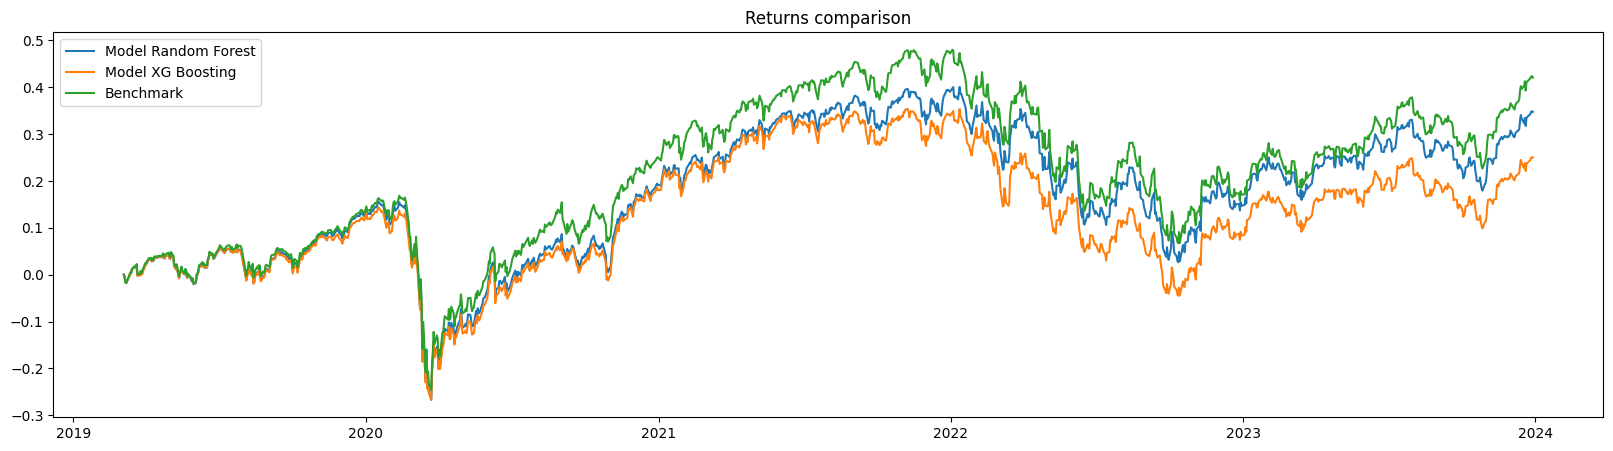

In [59]:
plt.figure(figsize=(20, 5))
plt.plot(cum_total_returns_random_forest, label='Model Random Forest')
plt.plot(cum_total_returns_xg_boosting, label='Model XG Boosting')
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.legend()
plt.title('Returns comparison')
plt.show()

In [60]:
df_results = pd.DataFrame(columns=['Annual Returns', 
                                   'Annual Volatility',
                                   'Sharpe Ratio',
                                   'Sortino Ratio',
                                   'Max Drawdown',
                                   'Max Time Under Water',
                                   'Calmar Ratio',
                                   'Information Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_returns_random_forest, df_results, 'Model Random Forest', benchmark_returns)
calculate_metrics(total_returns_xg_boosting, df_results, 'Model XG Boosting', benchmark_returns)

df_results

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Model Random Forest,0.063863,0.200814,0.318023,0.369067,-0.365862,493.0,0.174556,-0.450238
Model XG Boosting,0.047447,0.200858,0.236223,0.27701,-0.358791,538.0,0.132243,-0.65299
